In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
mass = 1.0
hbar = (1/5)**0.5
I_0 = 10.0
E = 2.0
V0 = 3.0
xi = 10.0

# Energy range 
n_energies = 24
energy_min, energy_max = 1.5, 2.3

# Channel indices
j_max = 20      # Increase for more channels if desired
j_vals = np.arange(-j_max, j_max+1)

# Compute k_j for each channel
k_vals = np.zeros(len(j_vals), dtype=complex)
for idx, j in enumerate(j_vals):
    val = 2 * mass * (E - ((j ** 2) * (hbar**2) / (2 * I_0)))
    if val >= 0:
        k_vals[idx] = np.sqrt(val)
    else:
        k_vals[idx] = 1j * np.sqrt(-val)

# Spatial grid
N = 300
L = 40.0
x = np.linspace(-L, L, N)
dx = x[1] - x[0]

# print(x)  
# print(k_vals)

In [2]:
# Green's function for channel j
def greens_function(xn, xm, kj):
    # Outgoing Green's function as per equation
    return -(1j * mass) / (hbar**2 * kj) * np.exp(1j * kj * np.abs(xn - xm))

# Coupled-channel potential (sum of three Gaussians)
def potential_triplet(x_p, xi=xi):
    m_vals = np.array([-1, 0, 1])
    return (V0)*(np.sum([np.exp(-(x_p - m*xi)**2) for m in m_vals]))


In [3]:
n_ch = len(j_vals)
dim = N * n_ch
K = np.zeros((dim, dim), dtype=np.complex128)

# # For each j,x pair, couple only j to j+1/j-1 via the potential
# for j_idx, j in enumerate(j_vals):
#     kj = k_vals[j_idx]
#     for xn_idx, xn in enumerate(x):
#         row_idx = j_idx * N + xn_idx
#         # Coupling to j-1
#         l = j - 1
#         if l in j_vals:
#             l_idx = np.where(j_vals == l)[0][0]
#             for xm_idx, xm in enumerate(x):
#                 col_idx = l_idx * N + xm_idx
#                 G_val = greens_function(xn, xm, kj)
#                 V_val = potential_triplet(xm)
#                 K[row_idx, col_idx] += G_val * V_val * dx
#         # Coupling to j+1
#         l = j + 1
#         if l in j_vals:
#             l_idx = np.where(j_vals == l)[0][0]
#             for xm_idx, xm in enumerate(x):
#                 col_idx = l_idx * N + xm_idx
#                 G_val = greens_function(xn, xm, kj)
#                 V_val = potential_triplet(xm)
#                 K[row_idx, col_idx] += G_val * V_val * dx
                


In [4]:
# Incident wave: only in the j=0 channel
phi = np.zeros(dim, dtype=np.complex128)
inc_channel = np.where(j_vals == 0)[0][0]
for xn_idx, xn_val in enumerate(x):
    idx = inc_channel * N + xn_idx
    phi[idx] = np.exp(1j * k_vals[inc_channel] * xn_val)

# inc_channel2 = np.where(j_vals == 1)[0][0]
# for xn_idx, xn_val in enumerate(x):
#     idx = inc_channel2 * N + xn_idx
#     phi[idx] = np.exp(1j * k_vals[inc_channel2] * xn_val)

# Solve (I - K) psi = phi
A = np.eye(dim, dtype=np.complex128) - K
psi = np.linalg.solve(A, phi)
psi_mat = psi.reshape((n_ch, N))  # shape: (num_channels, N)



In [5]:
# Choose x regions well outside the scattering region
refl_mask = x < -L/2
trans_mask = x > L/2

r_coeffs = np.zeros(n_ch, dtype=np.complex128)
t_coeffs = np.zeros(n_ch, dtype=np.complex128)

for idx_ch, kj in enumerate(k_vals):
    psi_refl = psi_mat[idx_ch, refl_mask]
    x_refl = x[refl_mask]
    M_refl = np.vstack([np.exp(1j*kj*x_refl), np.exp(-1j*kj*x_refl)]).T
    coeffs_refl, _, _, _ = np.linalg.lstsq(M_refl, psi_refl, rcond=None)
    r_coeffs[idx_ch] = coeffs_refl[1]  # reflected amplitude

    psi_trans = psi_mat[idx_ch, trans_mask]
    x_trans = x[trans_mask]
    ratios = psi_trans / np.exp(1j*kj*x_trans)
    t_coeffs[idx_ch] = np.mean(ratios)                                                    


In [6]:
# Choose x regions well outside the scattering region
refl_mask = x < -L/2
trans_mask = x > L/2

r_coeffs = np.zeros(n_ch, dtype=np.complex128)
t_coeffs = np.zeros(n_ch, dtype=np.complex128)

for idx_ch, kj in enumerate(k_vals):
    psi_refl = psi_mat[idx_ch, refl_mask]
    x_refl = x[refl_mask]
    M_refl = np.vstack([np.exp(1j*kj*x_refl), np.exp(-1j*kj*x_refl)]).T
    coeffs_refl, _, _, _ = np.linalg.lstsq(M_refl, psi_refl, rcond=None)
    r_coeffs[idx_ch] = coeffs_refl[1]  # reflected amplitude
    

    psi_trans = psi_mat[idx_ch, trans_mask]
    x_trans = x[trans_mask]
    ratios = psi_trans / np.exp(1j*kj*x_trans)
    t_coeffs[idx_ch] = np.mean(ratios)


In [7]:
def calculate_scattering_for_incident_channel(inc_channel_idx, k_vals, j_vals, x, dx, N, n_ch, K):
    """
    Calculate scattering coefficients for a specific incident channel
    Returns reflection and transmission coefficients for all channels
    """
    dim = N * n_ch
    
    # Incident wave in specified channel
    phi = np.zeros(dim, dtype=np.complex128)
    for xn_idx, xn_val in enumerate(x):
        idx = inc_channel_idx * N + xn_idx
        phi[idx] = np.exp(1j * k_vals[inc_channel_idx] * xn_val)
    
    # Solve linear system
    A = np.eye(dim, dtype=np.complex128) - K
    psi = np.linalg.solve(A, phi)
    psi_mat = psi.reshape((n_ch, N))
    
    # Extract coefficients
    refl_mask = x < -L/2
    trans_mask = x > L/2
    
    r_coeffs = np.zeros(n_ch, dtype=np.complex128)
    t_coeffs = np.zeros(n_ch, dtype=np.complex128)
    
    for idx_ch, kj in enumerate(k_vals):
        psi_refl = psi_mat[idx_ch, refl_mask]
        x_refl = x[refl_mask]
        M_refl = np.vstack([np.exp(1j*kj*x_refl), np.exp(-1j*kj*x_refl)]).T
        coeffs_refl, _, _, _ = np.linalg.lstsq(M_refl, psi_refl, rcond=None)
        r_coeffs[idx_ch] = coeffs_refl[1]  # reflected amplitude
        
        psi_trans = psi_mat[idx_ch, trans_mask]
        x_trans = x[trans_mask]
        ratios = psi_trans / np.exp(1j*kj*x_trans)
        t_coeffs[idx_ch] = np.mean(ratios)
    
    # Return as f_coeffs array: [channel, 0=reflection/1=transmission]
    f_coeffs = np.zeros((n_ch, 2), dtype=np.complex128)
    f_coeffs[:, 0] = r_coeffs
    f_coeffs[:, 1] = t_coeffs
    
    return f_coeffs


In [8]:
def construct_full_s_matrix(all_f_coeffs, k_vals, j_vals):
    """
    Construct the full S-matrix from f-coefficients
    S-matrix structure: (T R)
                       (R T)
    """
    # Get open channel indices (real k values)
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals[i]) < 1e-10]
    n_open_channels = len(open_channel_indices)
    
    print(f"Open channels: {[j_vals[i] for i in open_channel_indices]}")
    print(f"Number of open channels: {n_open_channels}")
    
    # Initialize S-matrix (2N x 2N for N open channels)
    S_matrix = np.zeros((2*n_open_channels, 2*n_open_channels), dtype=np.complex128)
    
    # Fill the S-matrix
    for i, inc_channel in enumerate(open_channel_indices):
        if inc_channel in all_f_coeffs:
            f_coeffs = all_f_coeffs[inc_channel]
            
            for j, out_channel in enumerate(open_channel_indices):
                # Extract coefficients
                r_coeff = f_coeffs[out_channel, 0]  # reflection
                t_coeff = f_coeffs[out_channel, 1]  # transmission
                
                # Fill 2x2 block: (T R)
                #                (R T)
                S_matrix[2*j, 2*i] = t_coeff      # T_ji
                S_matrix[2*j, 2*i+1] = r_coeff    # R_ji  
                S_matrix[2*j+1, 2*i] = r_coeff    # R_ji
                S_matrix[2*j+1, 2*i+1] = t_coeff  # T_ji
    
    return S_matrix




In [9]:
def build_K_matrix(k_vals, j_vals, x, dx, n_ch):
    """
    Construct the coupled-channel K matrix for given k_vals, channels, and spatial grid.
    Returns the K matrix.
    """
    N = len(x)
    dim = n_ch * N
    K = np.zeros((dim, dim), dtype=np.complex128)

    for j_idx, j in enumerate(j_vals):
        kj = k_vals[j_idx]
        for xn_idx, xn in enumerate(x):
            row_idx = j_idx * N + xn_idx
            # Coupling to j-1
            l = j - 1
            if l in j_vals:
                l_idx = np.where(j_vals == l)[0][0]
                for xm_idx, xm in enumerate(x):
                    col_idx = l_idx * N + xm_idx
                    G_val = greens_function(xn, xm, kj)
                    V_val = potential_triplet(xm)
                    K[row_idx, col_idx] += G_val * V_val * dx
            # Coupling to j+1
            l = j + 1
            if l in j_vals:
                l_idx = np.where(j_vals == l)[0][0]
                for xm_idx, xm in enumerate(x):
                    col_idx = l_idx * N + xm_idx
                    G_val = greens_function(xn, xm, kj)
                    V_val = potential_triplet(xm)
                    K[row_idx, col_idx] += G_val * V_val * dx
    return K


In [10]:
def calculate_k_values_for_energy(E_val, j_vals, mass, hbar, I_0):
    """Calculate k values for given energy"""
    k_vals_new = np.zeros(len(j_vals), dtype=complex)
    for idx, j in enumerate(j_vals):
        val = 2 * mass * (E_val - ((j ** 2) * (hbar**2) / (2 * I_0)))
        if val >= 0:
            k_vals_new[idx] = np.sqrt(val)
        else:
            k_vals_new[idx] = 1j * np.sqrt(-val)
    return k_vals_new

def single_energy_s_matrix(E_val, j_vals, x, dx, N, n_ch, mass, hbar, I_0):
    """Calculate S-matrix for a single energy with K matrix construction"""
    # Calculate k values for this energy
    k_vals_E = calculate_k_values_for_energy(E_val, j_vals, mass, hbar, I_0)
    
    # Build K matrix for this energy
    print(f"Building K matrix for E = {E_val:.3f}")
    K = build_K_matrix(k_vals_E, j_vals, x, dx, n_ch)
    
    # Get open channels for this energy
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals_E[i]) < 1e-10]
    
    # Only calculate for incident channels that are open and in range -3 to +3
    incident_channels = []
    inc_channel_range = range(-j_max, j_max + 1) # (-3,4) for n_ch = 8.
    for j_inc in inc_channel_range:
        if j_inc in j_vals:
            idx = np.where(j_vals == j_inc)[0][0]
            if idx in open_channel_indices:
                incident_channels.append(idx)
    
    print(f"  Open incident channels: {[j_vals[i] for i in incident_channels]}")
    
    # Calculate f-coefficients for all incident channels
    all_f_coeffs_E = {}
    for inc_idx in incident_channels:
        j_inc = j_vals[inc_idx]
        print(f"  Processing incident channel j = {j_inc}")
        
        f_coeffs = calculate_scattering_for_incident_channel(inc_idx, k_vals_E, j_vals, x, dx, N, n_ch, K)
        all_f_coeffs_E[inc_idx] = f_coeffs
        
        # Quick verification
        total_prob = np.sum(np.abs(f_coeffs[:, 0])**2 + np.abs(f_coeffs[:, 1])**2)
        print(f"    Total probability: {total_prob:.6f}")
    
    # Construct S-matrix
    S_matrix_E = construct_full_s_matrix(all_f_coeffs_E, k_vals_E, j_vals)
    
    return S_matrix_E, k_vals_E




In [11]:
def calculate_level_statistics(energy_range, j_vals, x, dx, N, n_ch, mass, hbar, I_0):
    """Calculate level spacing statistics over energy range"""
    all_eigenphases = []
    all_S_matrices = []
    valid_energies = []
    
    print(f"Calculating level statistics for {len(energy_range)} energy points...")
    
    for i, E_val in enumerate(energy_range):
        print(f"Processing energy {i+1}/{len(energy_range)}: E = {E_val:.3f}")
        
        try:
            S_matrix_E, k_vals_E = single_energy_s_matrix(E_val, j_vals, x, dx, N, n_ch, mass, hbar, I_0)
            
            # Skip if S-matrix is too small or has issues
            if S_matrix_E.shape[0] < 4:
                print(f"  Skipping E={E_val:.3f}: S-matrix too small")
                continue
            
            # Get eigenvalues and phases
            eigenvalues = np.linalg.eigvals(S_matrix_E)
            phases = np.angle(eigenvalues)
            
            # Remove nan or inf values
            phases = phases[np.isfinite(phases)]
            
            if len(phases) > 2:  # Need at least 3 phases for meaningful statistics
                all_eigenphases.append(phases)
                all_S_matrices.append(S_matrix_E)
                valid_energies.append(E_val)
                print(f"  Successfully processed: {len(phases)} eigenphases")
            else:
                print(f"  Skipping E={E_val:.3f}: insufficient valid phases")
            
        except Exception as e:
            print(f"  Error at E={E_val:.3f}: {e}")
            continue
    
    print(f"Successfully calculated S-matrices for {len(all_S_matrices)} energies")
    return all_eigenphases, all_S_matrices, valid_energies

# Define energy range (adjust based on computational resources)
# energy_min, energy_max = 1.5, 2.3
# n_energies = 5  # Start small for testing
energy_range = np.linspace(energy_min, energy_max, n_energies)

# Calculate level statistics
all_phases, all_S_mats, valid_energies = calculate_level_statistics(
    energy_range, j_vals, x, dx, N, n_ch, mass, hbar, I_0
)

print(f"\nSummary:")
print(f"Total energies attempted: {len(energy_range)}")
print(f"Successfully processed: {len(valid_energies)}")
print(f"Valid energies: {valid_energies}")


Calculating level statistics for 24 energy points...
Processing energy 1/24: E = 1.500
Building K matrix for E = 1.500
  Open incident channels: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Processing incident channel j = -12
    Total probability: 19912206480623038464.000000
  Processing incident channel j = -11
    Total probability: 31738055373405843456.000000
  Processing incident channel j = -10
    Total probability: 113204431901653827584.000000
  Processing incident channel j = -9
    Total probability: 13264738164969676800.000000
  Processing incident channel j = -8
    Total probability: 200181220956808642560.000000
  Processing incident channel j = -7
    Total probability: 174081248922288259072.000000
  Processing incident channel j = -6
    Total probability: 127589064099336896512.000000
  Processing incident channel j = -5
    Total probability: 31560174636251062272.000000
  Processing incident channel j = -4
    Total pro

In [12]:
def analyze_level_spacings(all_eigenphases):
    """Analyze level spacing statistics"""
    all_spacings = []
    all_ratios = []
    
    print("Analyzing level spacings...")
    
    for i, phases in enumerate(all_eigenphases):
        # Sort phases and calculate spacings
        sorted_phases = np.sort(phases)
        spacings = np.diff(sorted_phases)
        
        # Remove very small spacings (numerical artifacts)
        spacings = spacings[spacings > 1e-6]
        
        if len(spacings) > 1:
            # Normalize by mean spacing
            mean_spacing = np.mean(spacings)
            if mean_spacing > 1e-10:
                normalized_spacings = spacings / mean_spacing
                all_spacings.extend(normalized_spacings)
                
                # Calculate ratios for neighboring spacings
                for j in range(len(spacings)-1):
                    s1, s2 = spacings[j], spacings[j+1]
                    ratio = min(s1, s2) / max(s1, s2)
                    all_ratios.append(ratio)
                
                print(f"  Energy {i+1}: {len(spacings)} spacings, mean = {mean_spacing:.4f}")
    
    return np.array(all_spacings), np.array(all_ratios)

def classify_chaos(mean_ratio):
    """Classify the system based on level spacing ratio"""
    # Theoretical values:
    # Poisson (regular): ~0.386
    # GOE (chaotic): ~0.536
    # GUE (chaotic with time-reversal broken): ~0.603
    
    if mean_ratio > 0.53:
        return "Chaotic (GOE-like)"
    elif mean_ratio < 0.39:
        return "Regular (Poisson-like)"
    else:
        return "Intermediate"

# Analyze spacings if we have data
if len(all_phases) > 0:
    spacings, ratios = analyze_level_spacings(all_phases)
    
    if len(spacings) > 5 and len(ratios) > 5:
        # Calculate statistics
        mean_spacing = np.mean(spacings)
        std_spacing = np.std(spacings)
        mean_ratio = np.mean(ratios)
        std_ratio = np.std(ratios)
        
        print(f"\n{'='*50}")
        print(f"LEVEL SPACING STATISTICS")
        print(f"{'='*50}")
        print(f"Number of spacings analyzed: {len(spacings)}")
        print(f"Number of ratios analyzed: {len(ratios)}")
        print(f"Mean normalized spacing: {mean_spacing:.4f} ± {std_spacing:.4f}")
        print(f"Mean spacing ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
        
        # Classification
        chaos_classification = classify_chaos(mean_ratio)
        print(f"System classification: {chaos_classification}")
        
        # Additional chaos indicators
        print(f"\nChaos Indicators:")
        print(f"- Ratio < 0.39: Regular/Integrable")
        print(f"- Ratio ≈ 0.536: Chaotic (GOE)")
        print(f"- Ratio > 0.53: Chaotic")
        print(f"- Current ratio: {mean_ratio:.4f}")
        
    else:
        print("Insufficient data for meaningful level spacing analysis")
        print(f"Got {len(spacings)} spacings and {len(ratios)} ratios")
        print("Need at least 5 of each for reliable statistics")
else:
    print("No eigenphases calculated - check energy range and parameters")


Analyzing level spacings...
  Energy 1: 49 spacings, mean = 0.1244
  Energy 2: 49 spacings, mean = 0.1176
  Energy 3: 49 spacings, mean = 0.1227
  Energy 4: 49 spacings, mean = 0.1231
  Energy 5: 49 spacings, mean = 0.1250
  Energy 6: 49 spacings, mean = 0.1251
  Energy 7: 53 spacings, mean = 0.1168
  Energy 8: 53 spacings, mean = 0.1125
  Energy 9: 53 spacings, mean = 0.1141
  Energy 10: 53 spacings, mean = 0.1162
  Energy 11: 53 spacings, mean = 0.1112
  Energy 12: 53 spacings, mean = 0.1160
  Energy 13: 53 spacings, mean = 0.1176
  Energy 14: 53 spacings, mean = 0.1131
  Energy 15: 57 spacings, mean = 0.1085
  Energy 16: 57 spacings, mean = 0.1059
  Energy 17: 57 spacings, mean = 0.1078
  Energy 18: 57 spacings, mean = 0.1052
  Energy 19: 57 spacings, mean = 0.1059
  Energy 20: 57 spacings, mean = 0.1070
  Energy 21: 57 spacings, mean = 0.1077
  Energy 22: 57 spacings, mean = 0.1083
  Energy 23: 61 spacings, mean = 0.0990
  Energy 24: 61 spacings, mean = 0.0993

LEVEL SPACING STATIS

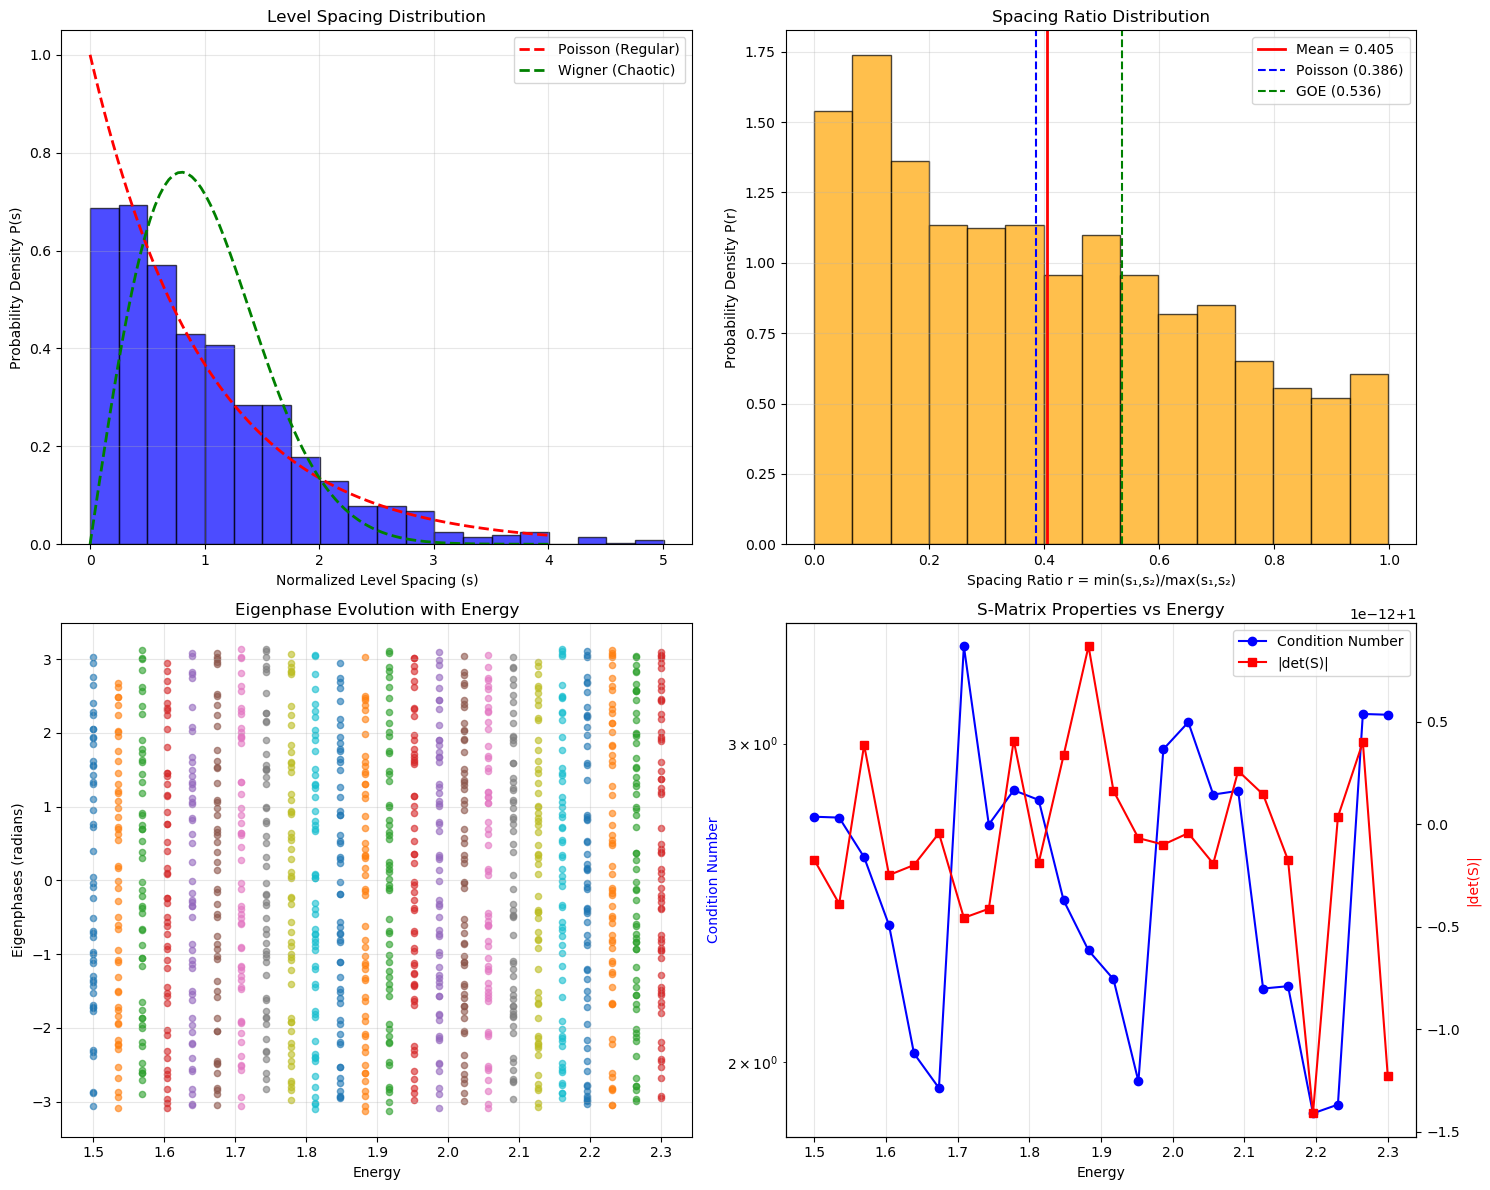


CHAOS ANALYSIS SUMMARY
Energy range: 1.50 - 2.30
Number of energies analyzed: 24
Total eigenphases: 1320
Mean spacing ratio: 0.4046 ± 0.2767
System classification: Intermediate
Unitarity check: All S-matrices should be unitary


In [13]:
import matplotlib.pyplot as plt

# Visualization of results
if len(all_phases) > 0 and len(spacings) > 5:
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Level spacing histogram
    ax1.hist(spacings, bins=min(20, len(spacings)//3), alpha=0.7, density=True, 
             color='blue', edgecolor='black')
    ax1.set_xlabel('Normalized Level Spacing (s)')
    ax1.set_ylabel('Probability Density P(s)')
    ax1.set_title('Level Spacing Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Add theoretical curves if enough data
    if len(spacings) > 20:
        s_theory = np.linspace(0, 4, 100)
        # Poisson: P(s) = exp(-s)
        poisson = np.exp(-s_theory)
        # Wigner-Dyson (GOE): P(s) = (π/2)s exp(-πs²/4)
        wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        
        ax1.plot(s_theory, poisson, 'r--', label='Poisson (Regular)', linewidth=2)
        ax1.plot(s_theory, wigner, 'g--', label='Wigner (Chaotic)', linewidth=2)
        ax1.legend()
    
    # Plot 2: Ratio histogram
    if len(ratios) > 5:
        ax2.hist(ratios, bins=min(15, len(ratios)//3), alpha=0.7, density=True, 
                 color='orange', edgecolor='black')
        ax2.axvline(x=mean_ratio, color='red', linestyle='-', linewidth=2, 
                   label=f'Mean = {mean_ratio:.3f}')
        ax2.axvline(x=0.386, color='blue', linestyle='--', label='Poisson (0.386)')
        ax2.axvline(x=0.536, color='green', linestyle='--', label='GOE (0.536)')
        ax2.set_xlabel('Spacing Ratio r = min(s₁,s₂)/max(s₁,s₂)')
        ax2.set_ylabel('Probability Density P(r)')
        ax2.set_title('Spacing Ratio Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Eigenphases vs Energy
    if len(valid_energies) > 1:
        for i, (E, phases) in enumerate(zip(valid_energies, all_phases)):
            ax3.scatter([E]*len(phases), phases, alpha=0.6, s=20)
        ax3.set_xlabel('Energy')
        ax3.set_ylabel('Eigenphases (radians)')
        ax3.set_title('Eigenphase Evolution with Energy')
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: S-matrix properties vs Energy
    if len(all_S_mats) > 1:
        condition_numbers = []
        determinants = []
        
        for S_mat in all_S_mats:
            condition_numbers.append(np.linalg.cond(S_mat))
            determinants.append(np.abs(np.linalg.det(S_mat)))
        
        ax4_twin = ax4.twinx()
        line1 = ax4.semilogy(valid_energies, condition_numbers, 'b-o', label='Condition Number')
        line2 = ax4_twin.plot(valid_energies, determinants, 'r-s', label='|det(S)|')
        
        ax4.set_xlabel('Energy')
        ax4.set_ylabel('Condition Number', color='b')
        ax4_twin.set_ylabel('|det(S)|', color='r')
        ax4.set_title('S-Matrix Properties vs Energy')
        ax4.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"\n{'='*60}")
    print(f"CHAOS ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Energy range: {energy_min:.2f} - {energy_max:.2f}")
    print(f"Number of energies analyzed: {len(valid_energies)}")
    print(f"Total eigenphases: {sum(len(phases) for phases in all_phases)}")
    print(f"Mean spacing ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
    print(f"System classification: {chaos_classification}")
    print(f"Unitarity check: All S-matrices should be unitary")
    
else:
    print("Insufficient data for visualization")
    print(f"Number of energy points with data: {len(all_phases)}")
    print(f"Number of spacings: {len(spacings) if 'spacings' in locals() else 0}")
